# Fitting a Line to Some Noisy Data
By Griffin Hosseinzadeh (2019 April 17)  
Updated by Charlotte Mason (2020 August 28)  
Updated by Griffin Hosseinzadeh (2025 April 28)  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Generate Some Fake Data
Choose a slope $m$, intercept $b$, and scatter $\sigma$, and generate $N$ random points using the `np.random` module. Plot the results to see what your data look like. Our goal is to recover the parameters defined here. (You are free to change them to whatever you want, but be aware that your plots may look different than others'.)

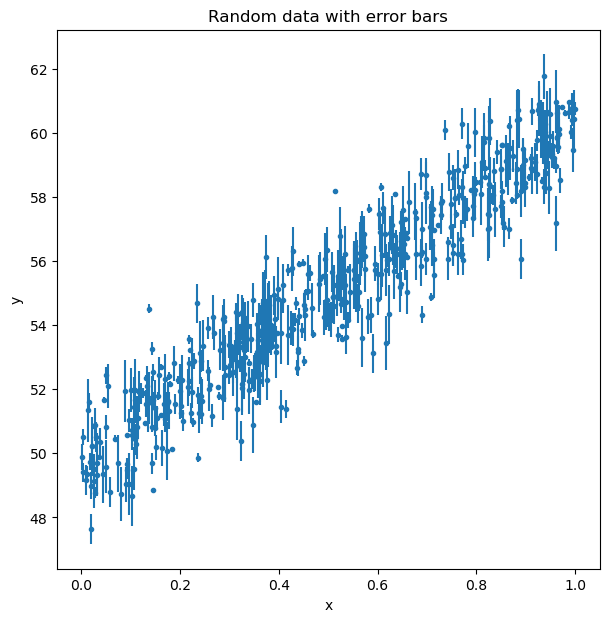

In [2]:
N = 500  # number of points
true_m = 10.  # slope
true_b = 50.  # intercept
sigma = 1.  # scatter

rng = np.random.default_rng(293746)
x =  rng.random((N,)) # complete with random values between 0 and 1
y =  (true_m * x + true_b) + np.random.normal(0, sigma, size=N)
# equation for a line PLUS random values from a Gaussian centered at 0 with standard deviation `sigma`
dy =  rng.random((N,)) # array of error bars for all the data (all `sigma`)

# plot your generated data with error bars
fig, ax = plt.subplots(figsize=(7,7))
ax.errorbar(x,y,dy,fmt='.')
ax.set_title("Random data with error bars")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Write Down the Posterior
Define functions that return the prior, the likelihood, and the posterior given a parameter vector `theta = [m, b]`. For computational accuracy (and convenience), we actually want to do this in log space. Regardless of the shape of your prior, it's good practice to limit the values of $m$ and $b$ to some reasonable range.

**Bayes Theorem**

The posterior is proportional to the likelihood $\mathcal{L}$ times the prior on the parameters $\boldsymbol{\theta} = m, b$:

$$ p(\boldsymbol{\theta} | \mathrm{data}) \propto \mathcal{L}(\mathrm{data} | \boldsymbol{\theta}) \times p(\boldsymbol{\theta}) $$

**Likelihood**

Assuming Gaussian errors, the likelihood for each data point given the model with parameters $\theta$ will be:

$$ \mathcal{L}_i(y_i | \boldsymbol{\theta}, x_i, \sigma_i) = \frac{1}{\sqrt{2\pi \sigma_i^2}} \exp\left[-\frac{(y_i - y_\mathrm{model}(x_i, \boldsymbol{\theta}))^2}{2 \sigma_i^2}\right] $$

Or in log space:

$$ \ln \mathcal{L}_i(y_i | \boldsymbol{\theta}, x_i, \sigma_i) = -\frac{1}{2} \left( \ln{2\pi \sigma_i^2}  + \left[\frac{y_i - y_\mathrm{model}(x_i, \boldsymbol{\theta})}{\sigma_i}\right]^2 \right) $$

Assuming the data are independent, the likelihood for obtaining all of the data points is the product of the individual likelihoods:

$$ \mathcal{L}(\mathbf{y} | \boldsymbol{\theta}, \mathbf{x}, \boldsymbol{\sigma}) = \prod_i \mathcal{L}_i(y_i | \boldsymbol{\theta}, x_i, \sigma_i) $$

Or in log space you can sum the log likelihoods:

$$ \ln \mathcal{L} = \ln \left(\prod_i \mathcal{L}_i \right) = \sum_i \ln \mathcal{L}_i $$

**Prior**

The simplest prior is a uniform prior to restrict the parameters to some range, e.g.:

$$ m = \begin{cases}
1, & 0 < m < 100\\
0, & \mathrm{otherwise}
\end{cases}$$

In [20]:
m_min = 0.
m_max = 100.
b_min = 0.
b_max = 100.

def log_prior(theta):
    """
    Returns log(prior) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    
    Returns
    -------
    ln_prior: float
        Natural log of the prior probability function
    """

    if theta[0] > m_min and theta[0] < m_max:
    
        ln_prior1 = -np.log(1/theta[0])

    else:
        ln_prior1 = -np.inf
    
    
    if theta[1] > b_min and theta[1] < b_max:
        
        ln_prior2 = -np.log(1/theta[1])
        
    else:
        ln_prior2 = -np.inf
        
    ln_prior = ln_prior1 + ln_prior2
    
    return ln_prior


def log_likelihood(theta, x, y, dy):
    """
    Returns log(likelihood) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    
    x: list, array-like
        List of independent variables from data
        
    y: list, array-like
        List of dependent variables from data
        
    dy: list, array-like
        List of errors from your y-data
    
    Returns
    -------
    ln_likelihood: float
        Natural log of the likelihood probability function
    """
    
    y_model = x * theta[0] + theta[1]
    
    all_ln_likelihoods = -1 * 0.5  *  ( np.log(2 * np.pi * sigma ** 2) + ( ( (y - y_model)  /  sigma)  ** 2))
                          
    ln_likelihood = np.sum(all_ln_likelihoods)
    
    return ln_likelihood


def log_posterior(theta, x, y, dy):
    """
    Returns log(posterior) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
        
    x: list, array-like
        List of independent variables from data
        
    y: list, array-like
        List of dependent variables from data
        
    dy: list, array-like
        List of errors from your y-data
        
    Returns
    -------
    ln_posterier: float
        Natural log of the posterior probabilty function
    """
    ln_likelihood = log_likelihood(theta, x, y, dy)
    ln_prior = log_prior(theta)

    ln_posterior = ln_likelihood + ln_prior
    
    return ln_posterior

## Evaluate it on a Grid
Now that you have defined `log_posterior`, produce a grid of $m$ and $b$ values, and evaluate the posterior at each point on the grid. Plot the results using `plt.contour` (contour plot) or `plt.contourf` (filled contour plot). Plot the input values of $m$ and $b$ as a point to see where they sit in the posterior space.

In [4]:
grid_spacing = 1.
m_range =  np.linspace(1,100,200)
b_range =  np.linspace(1,100,200)

m, b =  np.meshgrid(m_range, b_range)
ln_posteriors =  np.empty_like(m)

for i in range(np.shape(m)[0]):
    for j in range(np.shape(m)[1]):
        theta =  [m[i][j], b[i][j]]
        ln_posteriors[i][j] +=  (log_posterior(theta, x, y, dy))
        
posterior_grid =  np.exp(ln_posteriors - np.max(ln_posteriors))

In [5]:
# zooming into the non-trivial area...
# (I plotted 'posterior_grid' first, but still have to 
# separate cell from plotting cell to prevent RuntimeWarning)
m_range_zoom =  np.linspace(7,15,100)
b_range_zoom =  np.linspace(46,53,100)
m_zoom, b_zoom = np.meshgrid(m_range_zoom, b_range_zoom)

ln_posteriors_zoom =  np.empty_like(m_zoom)

for i in range(np.shape(m_zoom)[0]):
    for j in range(np.shape(m_zoom)[1]):
        theta =  [m_zoom[i][j], b_zoom[i][j]]
        ln_posteriors_zoom[i][j] +=  (log_posterior(theta, x, y, dy))
        
posterior_grid_zoom =  np.exp(ln_posteriors_zoom - np.max(ln_posteriors_zoom))

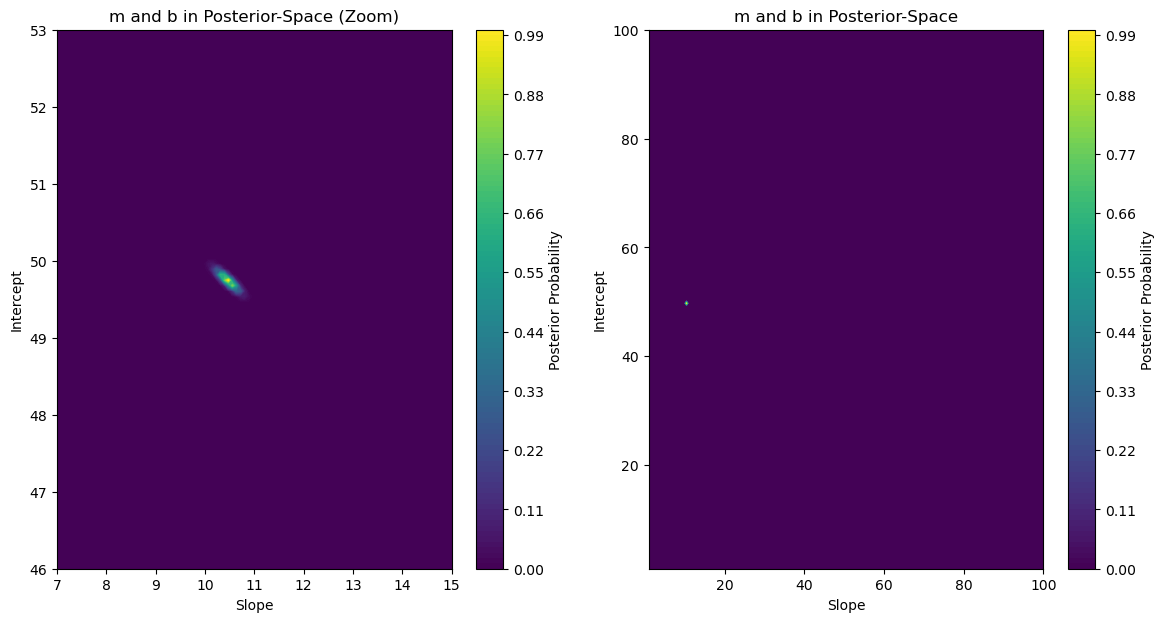

In [6]:
# I had to separate my calculations from the plotting
#   because of a RunTimeWarning that was messing with my data.

fig, ax =  plt.subplots(nrows=1, ncols=2, figsize=(14,7))

c = ax[1].contourf(m,b,posterior_grid, levels=100)
fig.colorbar(c, ax=ax[1], label='Posterior Probability')
ax[1].set_xlabel('Slope')
ax[1].set_ylabel('Intercept')
ax[1].set_title('m and b in Posterior-Space')


# plot zoomed-in area
c_zoom = ax[0].contourf(m_zoom,b_zoom,posterior_grid_zoom, levels=100)
fig.colorbar(c_zoom, ax=ax[0], label='Posterior Probability')
ax[0].set_xlabel('Slope')
ax[0].set_ylabel('Intercept')
ax[0].set_title('m and b in Posterior-Space (Zoom)')

plt.show()

Find the parameters that maximize the posterior distribution. How close did we come to the parameters we used to generate the data?

In [7]:
# Find the indices where the posterior is maximised --> what m and b is this?
j_max, i_max = np.unravel_index(np.argmax(posterior_grid), posterior_grid.shape)

m_infer = m_range[i_max]
b_infer = b_range[j_max]
print(f'm = {m_infer:.1f}, b = {b_infer:.1f}')

# Fractional error of the inferred solution compared to the input 'true' parameters
m_frac_err = abs(m_infer - true_m) / true_m
b_frac_err = abs(b_infer - true_b) / true_b
print(f'Δm/m = {m_frac_err:.3f}, Δb/b = {b_frac_err:.3f}')

m = 10.5, b = 49.8
Δm/m = 0.045, Δb/b = 0.005


### Marginalize Over Each Parameter
Since you have a grid of points, it is easy to integrate (sum) along the rows and columns of the grid. Use this method to find the marginalized posterior for each parameter and plot the results. How do the peaks of these distributions compare to our input parameters? (Hint: use the `axis` keyword in `np.sum`.) (Another hint: integrate the probability, not the log of the probability.)

**Marginalization**

If we just want to know the posterior for one parameter, we need to marginalize over all the possible values of the other parameter(s).

$$ p(\theta_1 | \mathrm{data}) = \int p(\theta_1, \theta_2 | \mathrm{data}) \, d\theta_2 $$

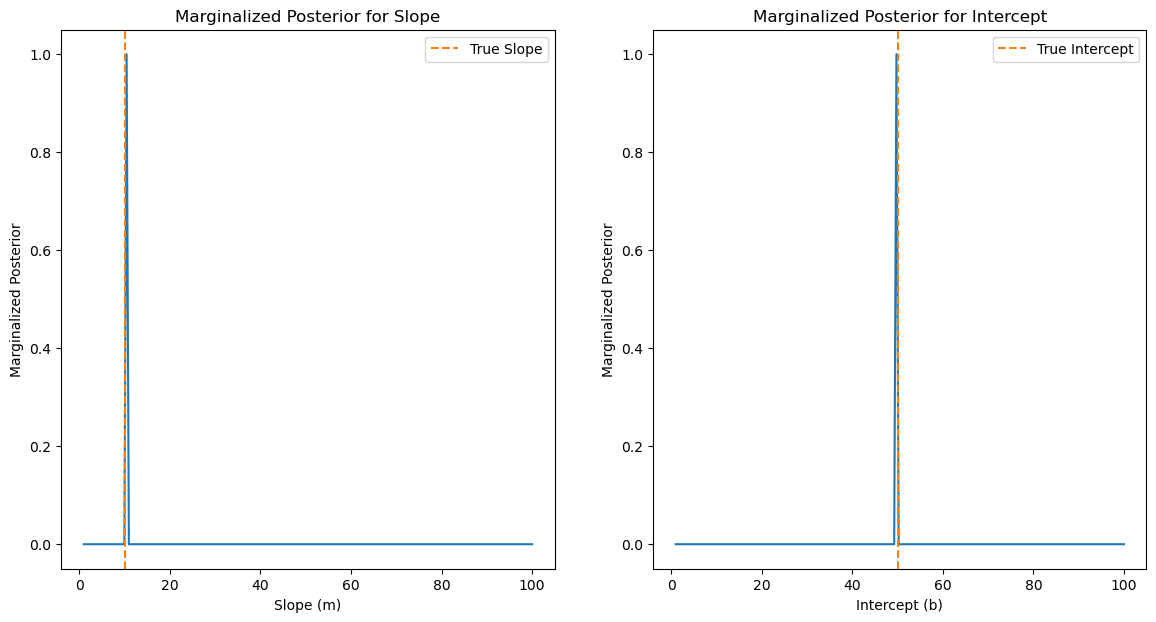

In [8]:
posterior_marginalized_m =  np.sum(posterior_grid, axis=0)
posterior_marginalized_b =  np.sum(posterior_grid, axis=1)


fig, ax =  plt.subplots(nrows=1, ncols=2, figsize=(14,7))

# plot the marginalized posterior for slope, m
ax[0].plot(m_range, posterior_marginalized_m, color='C0')
ax[0].axvline(true_m, color='C1', linestyle='--', label='True Slope')
ax[0].set_title('Marginalized Posterior for Slope')
ax[0].set_xlabel('Slope (m)')
ax[0].set_ylabel('Marginalized Posterior')
ax[0].legend()

# plot the marginalized posterior for intercept, b
ax[1].plot(b_range, posterior_marginalized_b, color='C0')
ax[1].axvline(true_b, color='C1', linestyle='--', label='True Intercept')
ax[1].set_title('Marginalized Posterior for Intercept')
ax[1].set_xlabel('Intercept (b)')
ax[1].set_ylabel('Marginalized Posterior')
ax[1].legend()

plt.show()

## Evaluate it on a Random Sample (Monte Carlo)
Instead of evaluating the posterior at every point on the grid, it can be more efficient to evaluate it on a random sample of points within the parameter space. Generate some random points using the `np.random` module and evaluate the posterior at each one. Plot them and color code by the posterior. (Use the `c` parameter of `plt.scatter`). Plot the input values of $m$ and $b$ as a point to see where they sit in the posterior space. How does this plot compare to the plot in the previous section?

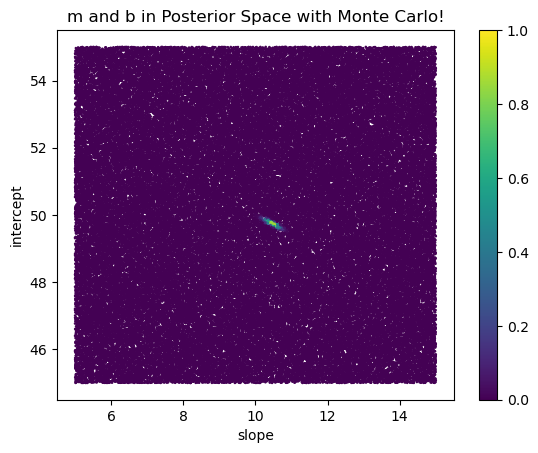

In [11]:
# 100k random values
m_random =  np.random.uniform(5,15,size=100000)
b_random =  np.random.uniform(45,55,size=100000)

# create an array with the posterior samples
ln_posterior_sample =  np.array([log_posterior([m,b],x,y,dy) for 
                                   m, b in zip(m_random, b_random)])

posterior_sample =  np.exp(ln_posterior_sample - np.max(ln_posterior_sample))

plt.scatter(m_random, b_random, c=posterior_sample, cmap='viridis', s=0.8)
plt.title('m and b in Posterior Space with Monte Carlo!')
plt.xlabel('slope')
plt.ylabel('intercept')
plt.colorbar()

plt.show()

As before, find the parameters that maximize the posterior distribution. How close did we come to the parameters we used to generate the data?

In [12]:
# Find the index of the sample where the posterior is maximised --> what m and b is this?
m_infer = m_random[i_max]
b_infer = b_random[i_max]
print(f'm = {m_infer:.1f}, b = {b_infer:.1f}')

# Fractional error of the inferred solution compared to the input 'true' parameters
m_frac_err = abs(m_infer - true_m) / true_m
b_frac_err = abs(b_infer - true_m) / true_m
print(f'Δm/m = {m_frac_err:.3f}, Δb/b = {b_frac_err:.3f}')

m = 8.8, b = 49.3
Δm/m = 0.120, Δb/b = 3.930


Note that it's complicated to calculate the marginalized posteriors using this method. You have to do some kind of binning or interpolation. Don't worry about that for now.

## Take-Away Message
Both methods work, but the point is it's wasteful (and impossible for higher dimensons or large $N$) to be sampling the posterior when the probability density is $e^{-100000}$. Later, we will see a much more efficient sampling method.

## Other Things to Try

### Redo the experiment but with a different prior. How much do your results change? Try plotting the priors on top of your marginalized posteriors.

I replace the log(uniform prior) with a log(gaussian prior)

In [25]:
m_min = 0.
m_max = 100.
b_min = 0.
b_max = 100.

def log_gaussian_prior(theta, dy, mu=0.0):
    """
    Returns log(gaussian_prior) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    
    mu: float
        Gaussian center (default = 0.0)
    
    dy: list, array-like
        y-error
    
    Returns
    -------
    ln_gprior: float
        Natural log of the gaussian prior probability function
    """

    sigma =  np.mean(dy)
    
    ln_gprior1 =  -1 * 0.5 * ((theta[0] - mu)**2 / sigma**2 + np.log(2 * np.pi * sigma**2))
    ln_gprior2 =  -1 * 0.5 * ((theta[1] - mu)**2 / sigma**2 + np.log(2 * np.pi * sigma**2))

    ln_gprior =  ln_gprior1 + ln_gprior2
    
    return ln_gprior


def log_gaussian_likelihood(theta, x, y, dy):
    """
    Returns log(gaussian likelihood) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    
    x: list, array-like
        List of independent variables from data
        
    y: list, array-like
        List of dependent variables from data
        
    dy: list, array-like
        List of errors from your y-data
    
    Returns
    -------
    ln_likelihood: float
        Natural log of the likelihood probability function
    """
    
    y_model = x * theta[0] + theta[1]
    
    residual =  y - y_model
    
    sigma =  np.mean(dy)
    
    ln_g_likelihood =  -1 * 0.5 * np.sum((residual / sigma)**2 + np.log(2 * np.pi * sigma**2))
    
    return ln_g_likelihood


def log_gaussian_posterior(theta, x, y, dy):
    """
    Returns log(gaussian posterior) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
        
    x: list, array-like
        List of independent variables from data
        
    y: list, array-like
        List of dependent variables from data
        
    dy: list, array-like
        List of errors from your y-data
        
    Returns
    -------
    ln_posterier: float
        Natural log of the posterior probabilty function
    """
    ln_glikelihood = log_gaussian_likelihood(theta, x, y, dy)
    ln_gprior = log_gaussian_prior(theta, dy)

    ln_gposterior = ln_glikelihood + ln_gprior
    
    return ln_gposterior

In [41]:
# 100k random values
mg_random =  np.random.uniform(5,15,size=100000)
bg_random =  np.random.uniform(45,55,size=100000)

# create an array with the posterior samples
ln_gp_sample =  np.array([log_gaussian_posterior([m,b],x,y,dy) for 
                                   m, b in zip(mg_random, bg_random)])

gposterior_sample =  np.exp(ln_gp_sample - np.max(ln_gp_sample))

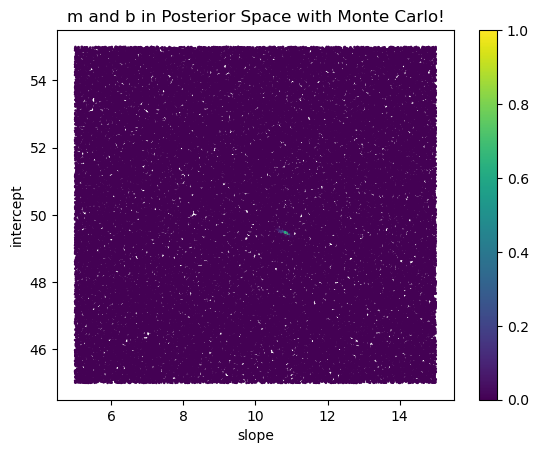

In [42]:
plt.scatter(mg_random, bg_random, c=gposterior_sample, cmap='viridis', s=0.8)
plt.title('m and b in Posterior Space with Monte Carlo!')
plt.xlabel('slope')
plt.ylabel('intercept')
plt.colorbar()

plt.show()

In [40]:
# Find the index of the sample where the posterior is maximised --> what m and b is this?
m_infer = mg_random[i_max]
b_infer = bg_random[i_max]
print(f'm = {m_infer:.1f}, b = {b_infer:.1f}')

# Fractional error of the inferred solution compared to the input 'true' parameters
m_frac_err = abs(m_infer - true_m) / true_m
b_frac_err = abs(b_infer - true_m) / true_m
print(f'Δm/m = {m_frac_err:.3f}, Δb/b = {b_frac_err:.3f}')

m = 12.8, b = 51.5
Δm/m = 0.280, Δb/b = 4.154


Based on the fractional error using the natural log of the gaussian prior, this prior is not fit for my data. When comparing the $\textbf{fractional error}$ of the intercept, it is quite large, which leads me to believe that I should stick to the log uniform prior.

### Redo the experiment but with a much larger scatter. How well do you do? Now do the priors affect your results?

The scatter that I chose was 100k sample of points because I wanted the Monte Carlo model to cover as much space as possible. Expanding on this, 100, was too sparse with a 0% posterior for all samples. 1000 and 10k would occasionally have only one point above 60% posterior. Having 100k samples gaurantees that I will get a good posterior and a better value for the fractional error of the inferred solution.

### Add another parameter to your model: the intrinsic scatter. See if you can recover the value you used to generate the noisy data.